# APRENDIZAJE AUTOMÁTICO
# Práctica 4: Regresión Logística Multiclase y Redes Neuronales
### Autor: Jiménez Omeñaca, David
### NIP:   825068   
### Fecha: 03/03/2025
---

---
## 0. Carga de datos de MNIST

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/
dataset = "mnist_784"
X, y = fetch_openml(dataset, version=1, return_X_y=True, as_frame=False, parser="pandas")
X = X / 255.0  # Escalar los datos entre 0 y 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=False)

print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape)
print('y_test.shape:', y_test.shape)


X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


In [2]:
from enum import IntFlag
from typing import Dict
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score

class Models:
    """
    A class to represent a collection of models and their computed metrics.

    This class is used to store, append, sort, and display metrics computed for multiple models.
    """
    
    def __init__(self):
        """
        Initializes an empty DataFrame to store model metrics.
        """
        self.df = pd.DataFrame()
    
    def append(self, model: pd.DataFrame):
        """
        Appends a new model's metrics to the collection.

        Parameters
        ----------

        model (pd.DataFrame) : A DataFrame containing the metrics of a single model.
        """
        self.df = pd.concat([self.df, model], axis=0, ignore_index=True)
    
    def sort(self, by: str, ascending: bool = True):
        """
        Sorts the stored models by a specified column.

        Parameters
        ----------

        by (str) : The column name by which to sort the models.
        ascending (bool, optional) : Whether to sort in ascending order. Defaults to True.
        """
        self.df = self.df.sort_values(axis=0, ascending=ascending, by=by)
    
    def print(self) -> pd.DataFrame:
        """
        Returns the stored DataFrame of model metrics.

        Returns
        -------

        pd.DataFrame : The DataFrame containing all appended model metrics.
        """
        return self.df


class ClassificationMetricsFlags(IntFlag):

    MEAN_PRECISSION = 1 << 0
    MEAN_RECALL = 1 << 1
    ACCURACY = 1 << 3
    BALANCED_ACCURACY = 1 << 4

class ClassificationMetrics():

    def __init__(self, y_real, y_pred, flags):
        self.y_real = y_real
        self.y_pred = y_pred
        self.flags = flags
        self.confusion_matrix = confusion_matrix(y_real, y_pred)
    
    def Mean_Precission(self):
        return precision_score(self.y_real, self.y_pred, average='weighted')

    def Mean_Recall(self):
        return recall_score(self.y_real, self.y_pred, average='weighted')

    def Accuracy(self):
        return accuracy_score(self.y_real, self.y_pred)
    
    def BalancedAccuracy(self):
        return balanced_accuracy_score(self.y_real, self.y_pred)
    
    def compute_metrics(self, name:str, r:int, beta:0.5) -> Dict[str, float]:
        metrics = {
            f'mean_prec_{name}': [round(self.Mean_Precission(), r)] if self.flags & ClassificationMetricsFlags.MEAN_PRECISSION else [],
            f'mean_recall_{name}': [round(self.Mean_Recall(), r)] if self.flags & ClassificationMetricsFlags.MEAN_RECALL else [],
            f'accuracy_{name}' : [round(self.Accuracy(), r)] if self.flags & ClassificationMetricsFlags.ACCURACY else [],
            f'bal_acc_{name}': [round(self.BalancedAccuracy(), r)] if self.flags & ClassificationMetricsFlags.BALANCED_ACCURACY else [],
        }
        return metrics
    
class LogisticMultiClassModel():
    def __init__(self, x_train, y_train, x_test, y_test, model, metrics, name):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = model
        self.metrics = metrics
        self.name = name
        import time
        now = time.time()
        self.model.fit(self.x_train, self.y_train)
        self.time = time.time() - now
    
    def compute_metrics(self, r=2):
        import time
        now = time.time()
        y_pred_train = self.model.predict(self.x_train)
        y_pred_test = self.model.predict(self.x_test)
        self.time_predict = time.time() - now
        train_metrics = ClassificationMetrics(self.y_train, y_pred_train, self.metrics)
        train_metrics = train_metrics.compute_metrics("train", r, 0.5)

        test_metrics = ClassificationMetrics(self.y_test, y_pred_test, self.metrics)
        test_metrics = test_metrics.compute_metrics("test", r, 0.5)

        metrics = {"Name": self.name, "Fit time":self.time, "Predict time":self.time_predict, **train_metrics, **test_metrics}
        metrics = {a:b for (a,b) in metrics.items() if b}
        metrics 

        return pd.DataFrame(metrics)
    
    def plot_example_real_vs_pred(self, predicted:str, real:str):
        y_pred = self.model.predict(self.x_test)
        idx = np.where((y_pred == predicted) & (self.y_test == real))[0]
        if len(idx) == 0:
            print("No se encontraron ejemplos con las características especificadas")
            return
        idx = idx[0]
        example = self.x_test[idx].flatten().reshape(28, 28)
        import matplotlib.pyplot as plt
        plt.imshow(example, cmap='gray')
        plt.title(f"Real: {real}, Predicted: {predicted}")

    def plot_confusion_matrix(self):
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
        y_pred = self.model.predict(self.x_test)
        conf = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf)
        disp.plot()
        disp.ax_.set_title(self.name)
        
       

In [3]:
models = Models()
flags = ClassificationMetricsFlags.MEAN_PRECISSION | ClassificationMetricsFlags.MEAN_RECALL | ClassificationMetricsFlags.ACCURACY | ClassificationMetricsFlags.BALANCED_ACCURACY

## Curvas de aprendizaje

Calculamos la curva de aprendizaje usando diferentes porcentajes de los datos de aprendizaje disponibles:



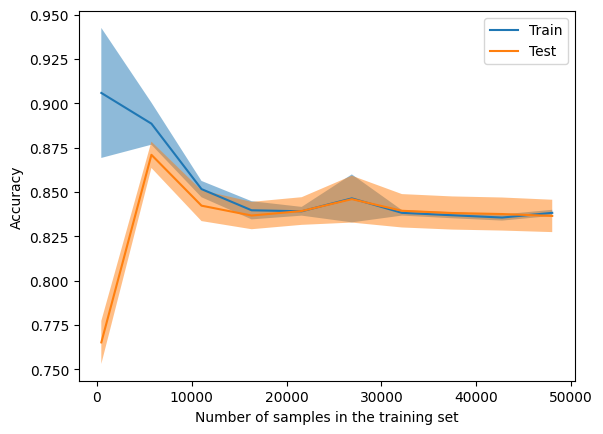

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LearningCurveDisplay


bins = np.linspace(0.01, 1, 10)

model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, tol=1e-2, n_jobs=-1)


LearningCurveDisplay.from_estimator(model, X_train, y_train, scoring='accuracy', train_sizes=bins, n_jobs=-1)

## Regresión logística

Ahora vamos a ajustar un modelo de regresión logística con regularización para clasificar los caracteres. Vamos a probar con:
- `lbfgs` porque funciona con multiclase y es bueno en general. Utiliza pérdida multinomial
- `sag` porque promete mejor tiempo de convergencia para problemas grandes. Utiliza pérdida multinomial
Por otro lado, también se va a probar a utilizar un modelo utilizando `OneVsRestClassifier` que realiza un ajuste binario para cada clase.

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,Log Reg - lbfgs,1.572779,0.101545,0.84,0.84,0.84,0.84,0.85,0.85,0.85,0.84


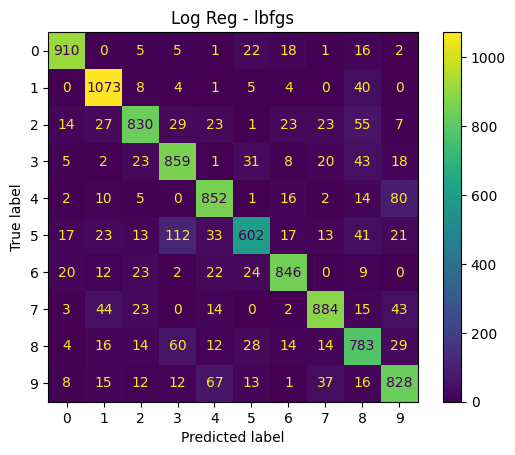

In [5]:
mod_1_lbfgs = LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-2, n_jobs=-1)

model_1_lbfgs = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_lbfgs, flags, "Log Reg - lbfgs")


models.append(model_1_lbfgs.compute_metrics())

model_1_lbfgs.plot_confusion_matrix()

model_1_lbfgs.compute_metrics()


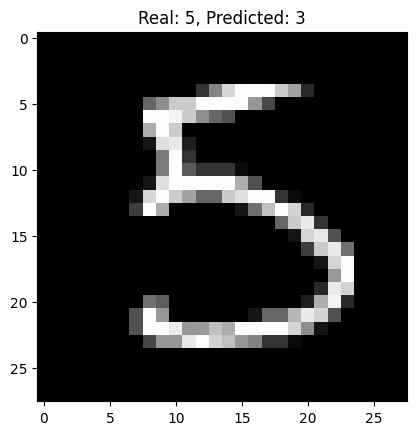

In [6]:
model_1_lbfgs.plot_example_real_vs_pred('3', '5')

También probamos con el solver `saga`:

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,Log Reg - sag,30.209371,0.088079,0.94,0.94,0.94,0.94,0.93,0.93,0.93,0.93


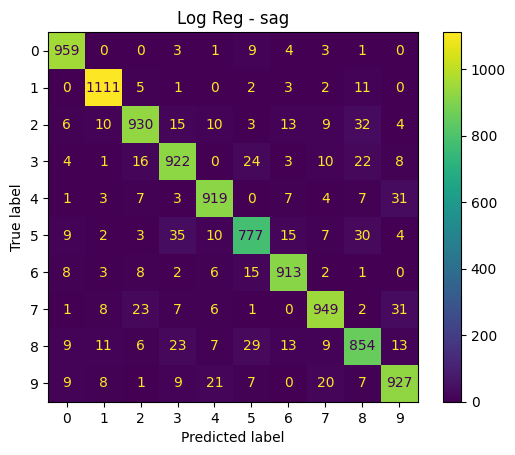

In [7]:
mod_1_sag = LogisticRegression(solver='sag', max_iter=1000, tol=1e-2, n_jobs=-1)

model_1_sag = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_sag, flags, "Log Reg - sag")

models.append(model_1_sag.compute_metrics())

model_1_sag.plot_confusion_matrix()
model_1_sag.compute_metrics()

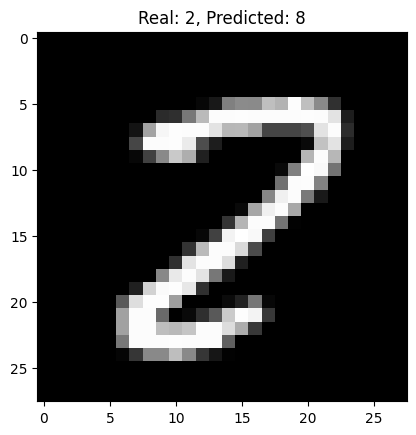

In [8]:
model_1_sag.plot_example_real_vs_pred('8', '2')

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,One vs Rest - sag,16.02788,0.470911,0.93,0.93,0.93,0.93,0.92,0.92,0.92,0.92


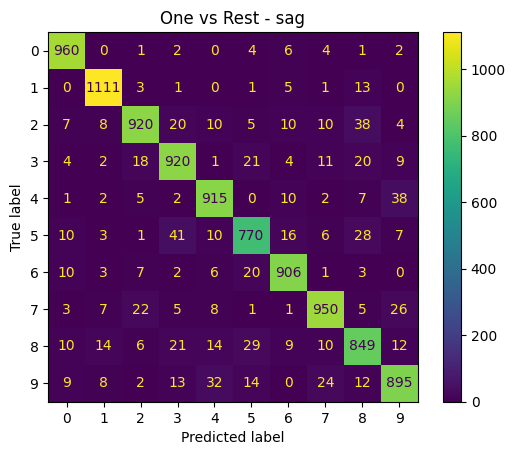

In [9]:
from sklearn.multiclass import OneVsRestClassifier
mod_1_one_vs_rest_sag = OneVsRestClassifier(LogisticRegression(solver='sag', max_iter=1000, tol=1e-2, n_jobs=-1), n_jobs=-1)

model_1_one_vs_rest_sag = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_one_vs_rest_sag, flags, "One vs Rest - sag")

models.append(model_1_one_vs_rest_sag.compute_metrics())

model_1_one_vs_rest_sag.plot_confusion_matrix()
model_1_one_vs_rest_sag.compute_metrics()

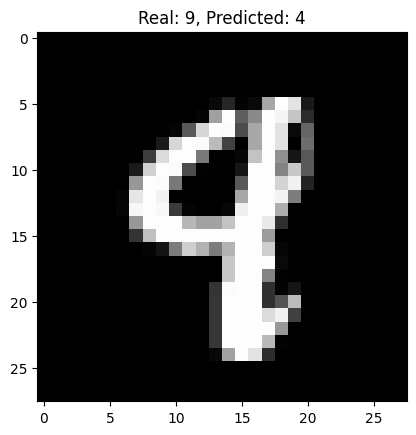

In [10]:
model_1_one_vs_rest_sag.plot_example_real_vs_pred('4', '9')

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,One vs Rest - lbfgs,2.482566,0.47689,0.87,0.87,0.87,0.87,0.88,0.88,0.88,0.88


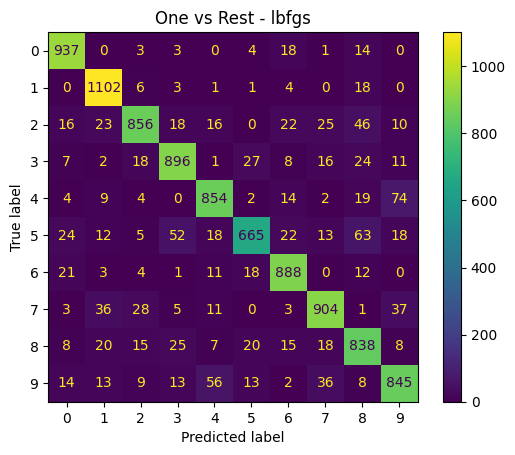

In [11]:
mod_1_one_vs_rest_lbfgs = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000, tol=1e-2, n_jobs=-1), n_jobs=-1)

model_1_one_vs_rest_lbfgs = LogisticMultiClassModel(X_train, y_train, X_test, y_test, mod_1_one_vs_rest_lbfgs, flags, "One vs Rest - lbfgs")

models.append(model_1_one_vs_rest_lbfgs.compute_metrics())

model_1_one_vs_rest_lbfgs.plot_confusion_matrix()
model_1_one_vs_rest_lbfgs.compute_metrics()

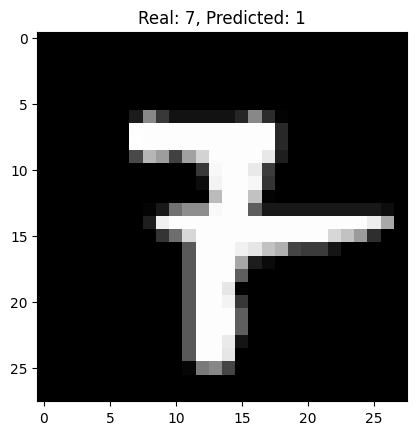

In [12]:
model_1_one_vs_rest_lbfgs.plot_example_real_vs_pred('1', '7')

Llegamos a las siguientes conclusiones:
- A pesar de que el tiempo de convergencia para `sag` es mucho mayor, se obtiene un mejor modelo aumentando en un `0.1` en el **accuracy**.
- Los modelos **one vs all**, llega a un modelo con accuracy similar, pero en la mitad de tiempo de convergencia que el modelo multinomial. Esto se debe a que son **más paralelizables**.
- Los modelos *OvA* tardan más en predecir, lo que tiene sentido ya que tienen que predecir en **todos los modelos ajustados**.

## Perceptrón sin capa oculta

Ahora entrenamos un modelo con perceptrón sin capa oculta.

,Name,Fit time,Predict time,mean_prec_train,mean_recall_train,accuracy_train,bal_acc_train,mean_prec_test,mean_recall_test,accuracy_test,bal_acc_test
0,Perceptron - No Hidden,1.769858,0.080312,0.89,0.88,0.88,0.88,0.89,0.87,0.87,0.87


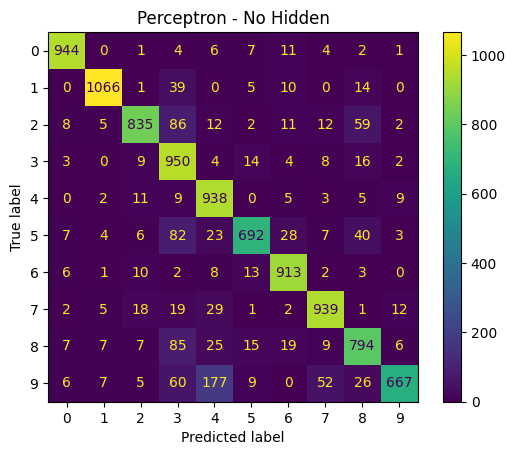

In [13]:
from sklearn.linear_model import Perceptron

perceptron_no_hidden = Perceptron(max_iter=1000, tol=1e-2, n_jobs=-1)

model_perceptron_no_hidden = LogisticMultiClassModel(X_train, y_train, X_test, y_test, perceptron_no_hidden, flags, "Perceptron - No Hidden")

models.append(model_perceptron_no_hidden.compute_metrics())

model_perceptron_no_hidden.plot_confusion_matrix()
model_perceptron_no_hidden.compute_metrics()

Contrario a otros modelos de clasificación binaria, podemos ver que ahora las redes neuronales a pesar de no tener capa oculta, se adaptan muy bien para modelos multiclase.

## Perceptrón con capa oculta
Ahora entrenamos un perceptrón con capa oculta. Vamos a aplicar un grid search para el número de neuronas.

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

perceptron_hidden_layer = MLPClassifier(max_iter=1000, tol=1e-2)

grid_values = [2**i for i in range(6, 11)]
grid_layers = [(_, ) for _ in grid_values]

grid_search = GridSearchCV(perceptron_hidden_layer, scoring='accuracy', param_grid={'hidden_layer_sizes': grid_layers}, n_jobs=-1, cv=3,  return_train_score=True,)

grid_search.fit(X_train, y_train)
grid_train_errors = grid_search.cv_results_['mean_train_score']
grid_test_errors = grid_search.cv_results_['mean_test_score']


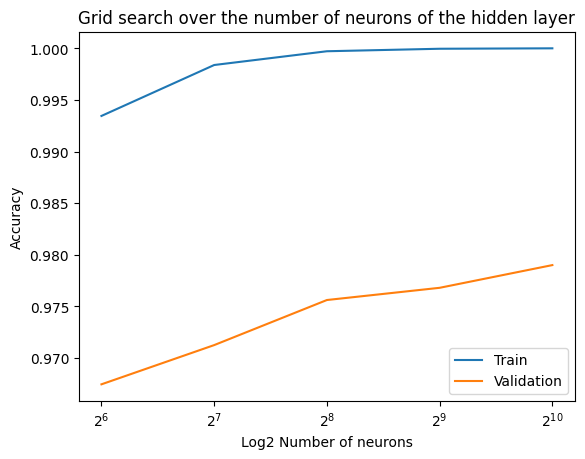

In [15]:
plt.plot(grid_values, grid_train_errors, label='Train')
plt.plot(grid_values, grid_test_errors, label='Validation')
plt.xscale('log', base=2)
plt.xlabel('Log2 Number of neurons')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Grid search over the number of neurons of the hidden layer")
plt.show()

In [16]:
# Best number of neurons
print("Best number of neurons: ", grid_search.best_params_['hidden_layer_sizes'])

Best number of neurons:  (1024,)


Ahora ajustamos este modelo con $2^{10}$ neuronas.

In [ ]:
model_hidden_layer = grid_search.best_estimator_

model_perceptron_hidden_layer = LogisticMultiClassModel(X_train, y_train, X_test, y_test, model_hidden_layer, flags, "Perceptron - Hidden Layer")

models.append(model_perceptron_hidden_layer.compute_metrics())

model_perceptron_hidden_layer.plot_confusion_matrix()
model_perceptron_hidden_layer.compute_metrics()

In [ ]:
model_perceptron_hidden_layer.plot_example_real_vs_pred('2', '7')   

Podemos observar que hemos obtenido un modelo casi perfecto, apoyando la idea presentada anteriormente. Los modelos neuronales para problemas multiclase tan grandes son muy adecuados, con el compromiso de un mayor tiempo de convergencia.

## Conclusiones finales

Analizamos todos los modelos de forma conjunta

In [ ]:
models.sort('accuracy_test', ascending=False)
models.print()

Aquí observamos que el mejor modelo con diferencia es el de redes neuronales con capa oculta, debido a la dimensión del modelo. Por otro lado, también vemos que el optimizador `saq` ha obtenido los segundos mejores resultados, tanto en multinomial como en *OvA*.

In [ ]:
models.df.to_csv("results_p4.csv")